In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.transforms import NormalizeScale
from torch_geometric.nn import knn_graph
from scipy.spatial import ConvexHull
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Function to load .off files
def load_off(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        if lines[0].strip() == 'OFF':
            lines = lines[1:]
        n_verts, n_faces, _ = map(int, lines[0].strip().split())
        vertices = np.array([list(map(float, lines[i + 1].strip().split())) for i in range(n_verts)])
        return vertices

# Custom dataset class for ModelNet10
class ModelNet10GraphDataset(InMemoryDataset):
    def __init__(self, root, split='train', transform=None, pre_transform=None):
        self.split = split
        self.class_to_idx = self.get_class_to_idx(root)
        super(ModelNet10GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [f'{self.split}_data.pt']

    def process(self):
        data_list = []
        #root_dir = self.raw_dir

        for cls in os.listdir(root_dir):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for split in ['train', 'test']:
                    split_dir = os.path.join(cls_dir, split)
                    if os.path.isdir(split_dir):
                        for file_name in os.listdir(split_dir):
                            if file_name.endswith('.off'):
                                file_path = os.path.join(split_dir, file_name)
                                point_cloud = load_off(file_path)
                                if len(point_cloud) > 1024:
                                    point_cloud = point_cloud[np.random.choice(len(point_cloud), 1024, replace=False)]
                                else:
                                    point_cloud = point_cloud[np.random.choice(len(point_cloud), 1024, replace=True)]
                                
                                # Calculate convex hull
                                hull = ConvexHull(point_cloud)
                                hull_vertices = point_cloud[hull.vertices]

                                # Combine point cloud and convex hull vertices
                                combined_points = np.vstack((point_cloud, hull_vertices))

                                pos = torch.tensor(combined_points, dtype=torch.float)
                                y = torch.tensor([self.class_to_idx[cls]], dtype=torch.long)
                                edge_index = knn_graph(pos, k=16)
                                data = Data(pos=pos, edge_index=edge_index, y=y)
                                data_list.append(data)
        
        if not data_list:
            raise RuntimeError("No data found. Please check your dataset directory and file structure.")
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def download(self):
        pass

    def get_class_to_idx(self, root_dir):
        classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return class_to_idx

# Ensure the dataset structure is correct
def verify_dataset_structure(root_dir):
    classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            train_dir = os.path.join(cls_dir, 'train')
            test_dir = os.path.join(cls_dir, 'test')
            if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
                raise RuntimeError(f"Expected 'train' and 'test' directories in {cls_dir}")
            print(f"Found class: {cls} with 'train' and 'test' subdirectories.")
        else:
            raise RuntimeError(f"Expected directory for class {cls} in {root_dir}")


In [3]:
# Define data paths
root_dir = 'C:/Users/Owner/Downloads/ModelNet10/ModelNet10'
verify_dataset_structure(root_dir)

train_dataset = ModelNet10GraphDataset(root=root_dir, split='train', pre_transform=NormalizeScale())
test_dataset = ModelNet10GraphDataset(root=root_dir, split='test', pre_transform=NormalizeScale())


Found class: bathtub with 'train' and 'test' subdirectories.
Found class: bed with 'train' and 'test' subdirectories.
Found class: chair with 'train' and 'test' subdirectories.
Found class: desk with 'train' and 'test' subdirectories.
Found class: dresser with 'train' and 'test' subdirectories.
Found class: monitor with 'train' and 'test' subdirectories.
Found class: night_stand with 'train' and 'test' subdirectories.
Found class: sofa with 'train' and 'test' subdirectories.
Found class: table with 'train' and 'test' subdirectories.
Found class: toilet with 'train' and 'test' subdirectories.


In [4]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# GNN model definition
class GCN(nn.Module):
    def __init__(self, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.pos, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [9]:
# Define model, loss function, and optimizer
num_classes = len(train_dataset.class_to_idx)
model = GCN(num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with progress bar and data tracking
num_epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for data in train_bar:
        data = data.to('cuda')

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        
        train_bar.set_postfix(loss=running_loss / (total / 32), accuracy=100. * correct / total)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)
    
    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to('cuda')
            outputs = model(data)
            loss = criterion(outputs, data.y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100. * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {100. * correct / total:.2f}%")

print('Finished Training')

Epoch 1/50: 100%|███████████████████████████████████████| 154/154 [00:15<00:00, 10.06batch/s, accuracy=27.5, loss=3.29]


Epoch 1, Test Loss: 2.1771, Test Accuracy: 40.91%


Epoch 2/50: 100%|███████████████████████████████████████| 154/154 [00:16<00:00,  9.61batch/s, accuracy=37.4, loss=2.53]


Epoch 2, Test Loss: 4.5093, Test Accuracy: 20.98%


Epoch 3/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.36batch/s, accuracy=42.5, loss=2.61]


Epoch 3, Test Loss: 1.7630, Test Accuracy: 48.66%


Epoch 4/50: 100%|█████████████████████████████████████████| 154/154 [00:14<00:00, 10.36batch/s, accuracy=51, loss=1.77]


Epoch 4, Test Loss: 1.6112, Test Accuracy: 50.81%


Epoch 5/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.29batch/s, accuracy=55.9, loss=1.48]


Epoch 5, Test Loss: 1.2045, Test Accuracy: 62.93%


Epoch 6/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.32batch/s, accuracy=63.2, loss=1.25]


Epoch 6, Test Loss: 1.0872, Test Accuracy: 66.87%


Epoch 7/50: 100%|███████████████████████████████████████| 154/154 [00:15<00:00, 10.27batch/s, accuracy=69.8, loss=1.05]


Epoch 7, Test Loss: 0.9758, Test Accuracy: 70.65%


Epoch 8/50: 100%|██████████████████████████████████████| 154/154 [00:15<00:00,  9.96batch/s, accuracy=72.2, loss=0.919]


Epoch 8, Test Loss: 0.8730, Test Accuracy: 74.24%


Epoch 9/50: 100%|██████████████████████████████████████| 154/154 [00:14<00:00, 10.36batch/s, accuracy=74.2, loss=0.845]


Epoch 9, Test Loss: 0.8441, Test Accuracy: 72.83%


Epoch 10/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.37batch/s, accuracy=73.8, loss=0.845]


Epoch 10, Test Loss: 0.7923, Test Accuracy: 74.83%


Epoch 11/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.27batch/s, accuracy=76.2, loss=0.748]


Epoch 11, Test Loss: 0.7125, Test Accuracy: 77.10%


Epoch 12/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.28batch/s, accuracy=77.1, loss=0.711]


Epoch 12, Test Loss: 0.6583, Test Accuracy: 77.93%


Epoch 13/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.34batch/s, accuracy=78.7, loss=0.658]


Epoch 13, Test Loss: 0.6782, Test Accuracy: 77.69%


Epoch 14/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.35batch/s, accuracy=78.1, loss=0.725]


Epoch 14, Test Loss: 0.7709, Test Accuracy: 76.40%


Epoch 15/50: 100%|██████████████████████████████████████| 154/154 [00:15<00:00, 10.23batch/s, accuracy=73.2, loss=1.16]


Epoch 15, Test Loss: 1.4354, Test Accuracy: 70.83%


Epoch 16/50: 100%|██████████████████████████████████████| 154/154 [00:15<00:00,  9.71batch/s, accuracy=67.5, loss=1.59]


Epoch 16, Test Loss: 0.8623, Test Accuracy: 75.63%


Epoch 17/50: 100%|██████████████████████████████████████| 154/154 [00:14<00:00, 10.33batch/s, accuracy=71.2, loss=1.44]


Epoch 17, Test Loss: 1.2377, Test Accuracy: 66.16%


Epoch 18/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00, 10.25batch/s, accuracy=75.6, loss=0.818]


Epoch 18, Test Loss: 0.7403, Test Accuracy: 77.49%


Epoch 19/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00, 10.23batch/s, accuracy=77.6, loss=0.694]


Epoch 19, Test Loss: 0.6218, Test Accuracy: 79.32%


Epoch 20/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.32batch/s, accuracy=79.4, loss=0.633]


Epoch 20, Test Loss: 0.6249, Test Accuracy: 78.89%


Epoch 21/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.30batch/s, accuracy=79.5, loss=0.621]


Epoch 21, Test Loss: 0.5847, Test Accuracy: 81.22%


Epoch 22/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.32batch/s, accuracy=81.1, loss=0.596]


Epoch 22, Test Loss: 0.5675, Test Accuracy: 81.49%


Epoch 23/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.84batch/s, accuracy=81, loss=0.582]


Epoch 23, Test Loss: 0.5317, Test Accuracy: 82.32%


Epoch 24/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.75batch/s, accuracy=81.9, loss=0.568]


Epoch 24, Test Loss: 0.5456, Test Accuracy: 81.98%


Epoch 25/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00,  9.79batch/s, accuracy=82.1, loss=0.535]


Epoch 25, Test Loss: 0.5422, Test Accuracy: 81.38%


Epoch 26/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.34batch/s, accuracy=82.2, loss=0.533]


Epoch 26, Test Loss: 0.5233, Test Accuracy: 83.45%


Epoch 27/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.28batch/s, accuracy=81.7, loss=0.565]


Epoch 27, Test Loss: 0.6733, Test Accuracy: 82.67%


Epoch 28/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.34batch/s, accuracy=80.4, loss=0.783]


Epoch 28, Test Loss: 0.8562, Test Accuracy: 76.34%


Epoch 29/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.35batch/s, accuracy=79.9, loss=0.703]


Epoch 29, Test Loss: 0.5335, Test Accuracy: 82.51%


Epoch 30/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00, 10.27batch/s, accuracy=80.6, loss=0.695]


Epoch 30, Test Loss: 4.8563, Test Accuracy: 62.54%


Epoch 31/50: 100%|████████████████████████████████████████| 154/154 [00:14<00:00, 10.33batch/s, accuracy=59, loss=4.66]


Epoch 31, Test Loss: 1.3488, Test Accuracy: 68.75%


Epoch 32/50: 100%|███████████████████████████████████████| 154/154 [00:15<00:00, 10.23batch/s, accuracy=68.9, loss=1.5]


Epoch 32, Test Loss: 0.8133, Test Accuracy: 76.67%


Epoch 33/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.33batch/s, accuracy=76.9, loss=0.802]


Epoch 33, Test Loss: 0.7131, Test Accuracy: 77.87%


Epoch 34/50: 100%|██████████████████████████████████████| 154/154 [00:15<00:00, 10.02batch/s, accuracy=78.8, loss=0.66]


Epoch 34, Test Loss: 0.5945, Test Accuracy: 80.42%


Epoch 35/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00,  9.89batch/s, accuracy=80.8, loss=0.605]


Epoch 35, Test Loss: 0.6341, Test Accuracy: 78.36%


Epoch 36/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.57batch/s, accuracy=81.2, loss=0.584]


Epoch 36, Test Loss: 0.5268, Test Accuracy: 82.34%


Epoch 37/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.58batch/s, accuracy=77.6, loss=1.11]


Epoch 37, Test Loss: 2.5601, Test Accuracy: 71.08%


Epoch 38/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.56batch/s, accuracy=76.5, loss=1.03]


Epoch 38, Test Loss: 0.9111, Test Accuracy: 76.46%


Epoch 39/50: 100%|███████████████████████████████████████| 154/154 [00:16<00:00,  9.57batch/s, accuracy=79, loss=0.768]


Epoch 39, Test Loss: 0.5849, Test Accuracy: 81.06%


Epoch 40/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.57batch/s, accuracy=81.9, loss=0.577]


Epoch 40, Test Loss: 0.5280, Test Accuracy: 82.63%


Epoch 41/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.55batch/s, accuracy=83.1, loss=0.518]


Epoch 41, Test Loss: 0.4825, Test Accuracy: 84.02%


Epoch 42/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.57batch/s, accuracy=83.5, loss=0.492]


Epoch 42, Test Loss: 0.4648, Test Accuracy: 84.69%


Epoch 43/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.56batch/s, accuracy=84.1, loss=0.475]


Epoch 43, Test Loss: 0.4414, Test Accuracy: 85.43%


Epoch 44/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.53batch/s, accuracy=85.1, loss=0.453]


Epoch 44, Test Loss: 0.4373, Test Accuracy: 85.10%


Epoch 45/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.56batch/s, accuracy=83.6, loss=0.489]


Epoch 45, Test Loss: 0.4525, Test Accuracy: 84.81%


Epoch 46/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00,  9.77batch/s, accuracy=85.1, loss=0.464]


Epoch 46, Test Loss: 0.5050, Test Accuracy: 85.08%


Epoch 47/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.41batch/s, accuracy=85.2, loss=0.46]


Epoch 47, Test Loss: 0.4357, Test Accuracy: 85.20%


Epoch 48/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.40batch/s, accuracy=85.5, loss=0.426]


Epoch 48, Test Loss: 0.4070, Test Accuracy: 86.75%


Epoch 49/50: 100%|███████████████████████████████████████| 154/154 [00:16<00:00,  9.45batch/s, accuracy=86, loss=0.425]


Epoch 49, Test Loss: 0.4175, Test Accuracy: 86.61%


Epoch 50/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.38batch/s, accuracy=86.1, loss=0.428]


Epoch 50, Test Loss: 0.3888, Test Accuracy: 87.04%
Finished Training


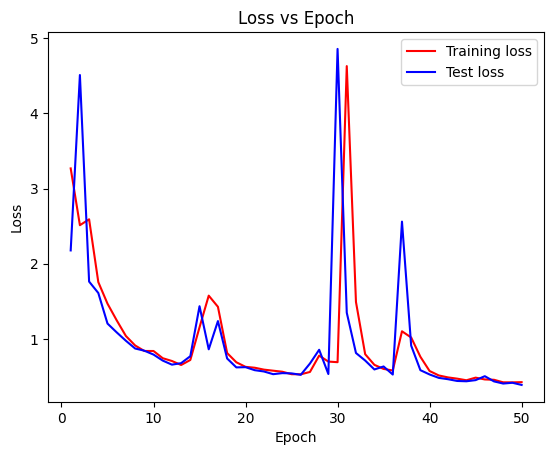

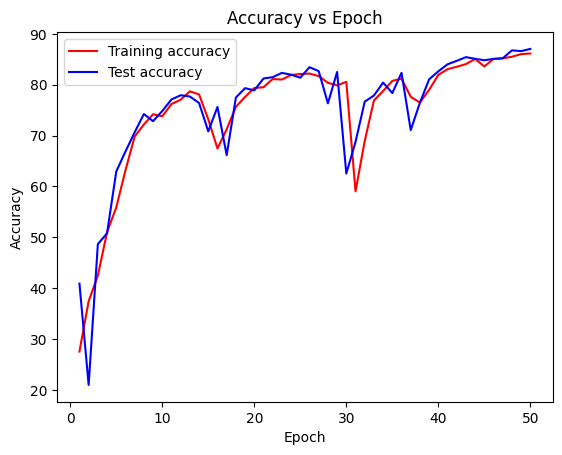

In [10]:
# Plot accuracy and loss vs epoch
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='Test loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()